In [106]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from pathlib import Path
from utilities.helper_functions import accuracy_fn

from timeit import default_timer as timer

torch.__version__, torchvision.__version__

d:\Work\Coding\Machine-Learning\PyTorch\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


('2.7.1+cu118', '0.22.1+cu118')

## Device agnostic code

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Get FashionMNIST dataset

In [3]:
# setup training data
train_data = datasets.FashionMNIST(
    root="datasets",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

# setup testig data
test_data = datasets.FashionMNIST(
    root="datasets",
    train=False,
    download=True,
    transform=ToTensor()
)

In [4]:
# see first training sample
images, label = train_data[0]
images.shape, label

(torch.Size([1, 28, 28]), 9)

In [5]:
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

In [6]:
image, label = train_data[0]
classes= train_data.classes
# label = 9
label = classes[label]
label

'Ankle boot'

### Let's visualize

Image shape before squeeze: torch.Size([1, 28, 28])
Image shape after squeeze: torch.Size([28, 28])


Text(0.5, 1.0, 'Ankle boot')

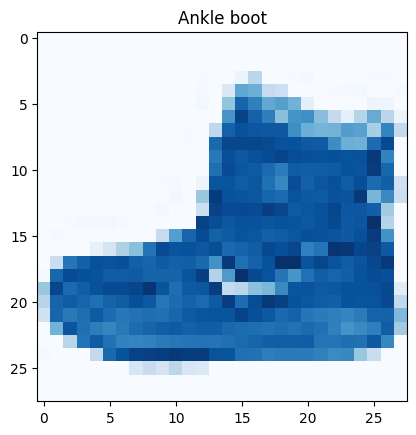

In [7]:
image, label = train_data[0]

print(f"Image shape before squeeze: {image.shape}")
image = image.squeeze()
print(f"Image shape after squeeze: {image.shape}")

plt.imshow(image, cmap=plt.cm.Blues)
plt.title(classes[label])

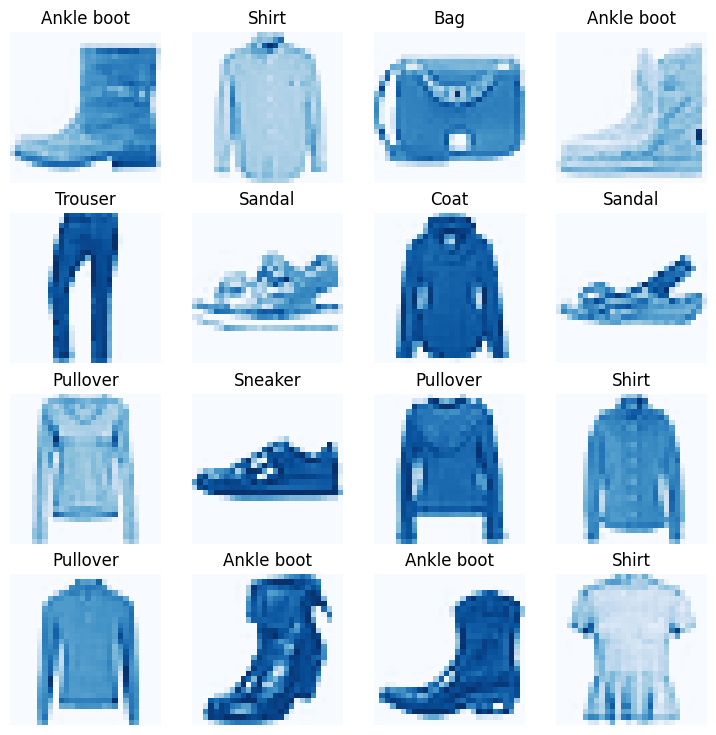

In [8]:
# plot more images

torch.manual_seed(42)

fig = plt.figure(figsize=(9, 9))

rows, cols = 4, 4

for i in range(1, rows*cols + 1):

    random_index = torch.randint(0, len(train_data), size=[1]).item()
    image, label = train_data[random_index]

    plt.subplot(rows, cols, i)
    plt.imshow(image.squeeze(), cmap=plt.cm.Blues)
    plt.title(classes[label])
    plt.axis(False)

## Prepare Dataloader

In [20]:
BATCH_SIZE = 32

train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x000002CDAEB86850>, <torch.utils.data.dataloader.DataLoader object at 0x000002CDAF7C4750>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [42]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [43]:
train_features_batch.permute(0, 2, 3, 1).shape

torch.Size([32, 28, 28, 1])

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

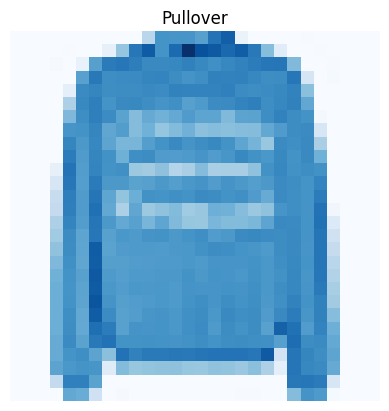

In [87]:

random_index = torch.randint(0, len(train_features_batch), size=[1]).item()

image, label = train_features_batch[random_index], train_labels_batch[random_index]

plt.title(classes[label])
plt.imshow(image.squeeze(), cmap=plt.cm.Blues)
plt.axis(False)

## Plot first batch

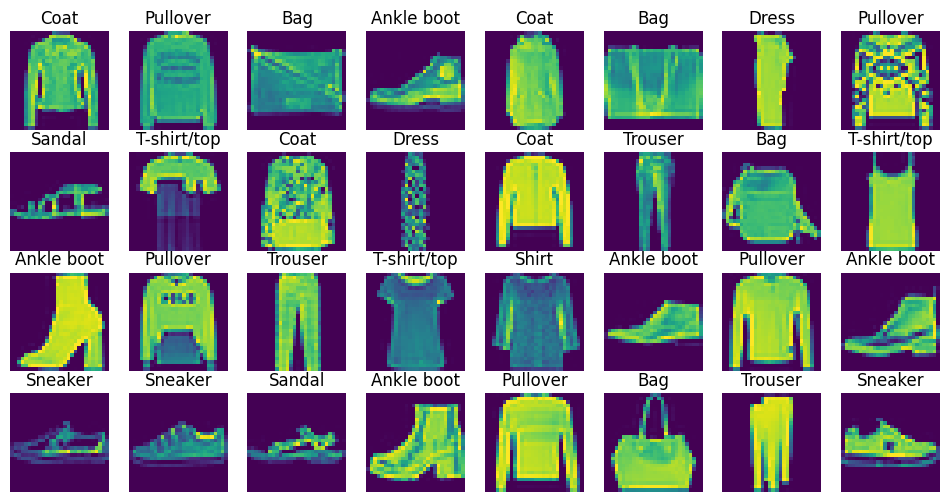

In [89]:
train_features_batch.shape, train_labels_batch.shape

rows, cols = 4, 8

plt.figure(figsize=(12,6))

for i in range(0, rows * cols):

    image, label = train_features_batch[i], train_labels_batch[i]
    
    plt.subplot(rows, cols, i + 1)

    plt.title(classes[label])
    plt.imshow(image.squeeze())
    plt.axis(False)

## Model 0: Build a baseline model

In [92]:
flatten_model = nn.Flatten()

x = train_features_batch[0]

output = flatten_model(x)


print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

Shape before flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channels, height*width]


In [93]:
class FashionMNISTModelV0(nn.Module):

    def __init__(self, input_shape: int, output_shape: int, hidden_units: int):
        super().__init__()

        self.layer_stack = nn.Sequential(

            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=input_shape, out_features=output_shape)
        )

    def forward(self, x: torch.tensor) -> torch.tensor:

        return self.layer_stack(x)    

In [97]:
torch.manual_seed(42)

model_0 = FashionMNISTModelV0(
    input_shape=784,
    hidden_units=10,
    output_shape=len(classes)
)

next(model_0.parameters()).device, model_0

(device(type='cpu'),
 FashionMNISTModelV0(
   (layer_stack): Sequential(
     (0): Flatten(start_dim=1, end_dim=-1)
     (1): Linear(in_features=784, out_features=10, bias=True)
     (2): Linear(in_features=784, out_features=10, bias=True)
   )
 ))

## Setup loss, optimizer and evaluation metrics

In [99]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params= model_0.parameters(),
                            lr=0.01)

## we'll compare time between the models using different devices

In [104]:
def print_train_time(start: float, end: float, device: torch.device = None):

    total_time = start - end
    print(f"Train time on {device}: {total_time: 3f} seconds")

    return total_time

In [ ]:
torch.manual_seed(42)
train_time_start_on_cpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):

    print(f"Epoch: {epoch}\n-------")
    ### Training